In [1]:
from modular import  model_builder
from modular.data_aug import thermal_train_strong_transform,thermal_test_transform
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)



In [ ]:
num_epochs = [10]
embedding_dims = [128]  # Example of testing different embedding dimensions
experiment_name = "Resnet18_data_aug
" \
""

In [3]:
from pathlib import Path
from modular.data_setup import setup_fsl_train_test_dataloaders
data_path = Path("data/")
TRAIN_EPISODES=200
TEST_EPISDOES=200
N_WAY=5
K_SHOT=2
Q_QUERY=5

train_loader, test_loader, fsl_dataset, _ = setup_fsl_train_test_dataloaders(
    data_path=data_path,
    transform=thermal_train_strong_transform,
    train_episodes=TRAIN_EPISODES,
    test_episodes=TEST_EPISDOES,
    n_way=N_WAY,
    k_shot=K_SHOT,
    q_query=Q_QUERY,
)

Dataset class distribution: {0: 38, 1: 31, 2: 42, 3: 31, 4: 38, 5: 34, 6: 37, 7: 35, 8: 28, 9: 25, 10: 30}
Found 11 valid classes with at least 7 samples each
Automatically split classes:
  Training classes (6): Rotor-0, A&C&B10, A&B50, A&C30, Noload, A30
  Testing classes (5): A10, Fan, A&C&B30, A&C10, A50
Training class distribution: {0: 38, 1: 31, 4: 38, 6: 37, 9: 25, 10: 30}
Testing class distribution: {2: 42, 3: 31, 5: 34, 7: 35, 8: 28}
Using n_way=5 for training, n_way=5 for testing
Valid classes for sampling: 6
Classes with counts: [(0, 38), (1, 31), (4, 38), (6, 37), (9, 25), (10, 30)]
Valid classes for sampling: 5
Classes with counts: [(2, 42), (3, 31), (5, 34), (7, 35), (8, 28)]


In [4]:
#Loop through experiments

from modular.utils import create_writer,save_model
from modular.engine import train_prototype_network
experiment_number = 0
for embedding_dim in embedding_dims:
    for epochs in num_epochs:
        experiment_number += 1
        print(f"[INFO] Running Experiment {experiment_number}")
        print(f"[INFO] Embedding Dim: {embedding_dim}, Epochs: {epochs}")
        
        # Create model
        model = model_builder.MobileNetV2(embedding_dim=embedding_dim).to(device)
        
        # Define optimizer
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4,lr=0.001)
        
        # Create TensorBoard writer
        writer = create_writer(
            experiment_name=experiment_name,
            model_name=f"PrototypicalNetwork_{embedding_dim}",
            extra=f"{epochs}_epochs"
        )
        
        # Train the model
        results = train_prototype_network(
            model=model,
            train_dataloader=train_loader,
            test_dataloader=test_loader,
            optimizer=optimizer,
            n_way=N_WAY,
            epochs=epochs,
            device=device,
            writer=writer
        )
        save_filepath = f"Resnet18_NWAY_{N_WAY}_KSHOT_{K_SHOT}_QQUERY_{Q_QUERY}_epochs_{epochs}.pth"
        save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
        print("-" * 50 +"\n")

[INFO] Running Experiment 1
[INFO] Embedding Dim: 128, Epochs: 10
[INFO] Created SummaryWriter, saving to: runs\2025-05-02\MovbileNetV2\PrototypicalNetwork_128\10_epochs...


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 1.3710 | Train Acc: 0.4804 | Test Loss: 1.3195 | Test Acc: 0.5588

Epoch 6/10
Train Loss: 1.2035 | Train Acc: 0.5806 | Test Loss: 1.1690 | Test Acc: 0.6512
 epoch 9 with best test accuracy: 0.6442
[INFO] Saving model to: models\Resnet18_NWAY_5_KSHOT_2_QQUERY_5_epochs_10.pth
--------------------------------------------------



Final Training Loss: 1.2041, Final Testing Loss: 1.1858
Final Training Accuracy: 0.5770, Final Testing Accuracy: 0.6442
Model appears to be generalizing well with minimal overfitting.
Best testing accuracy 0.6558 achieved at epoch 9


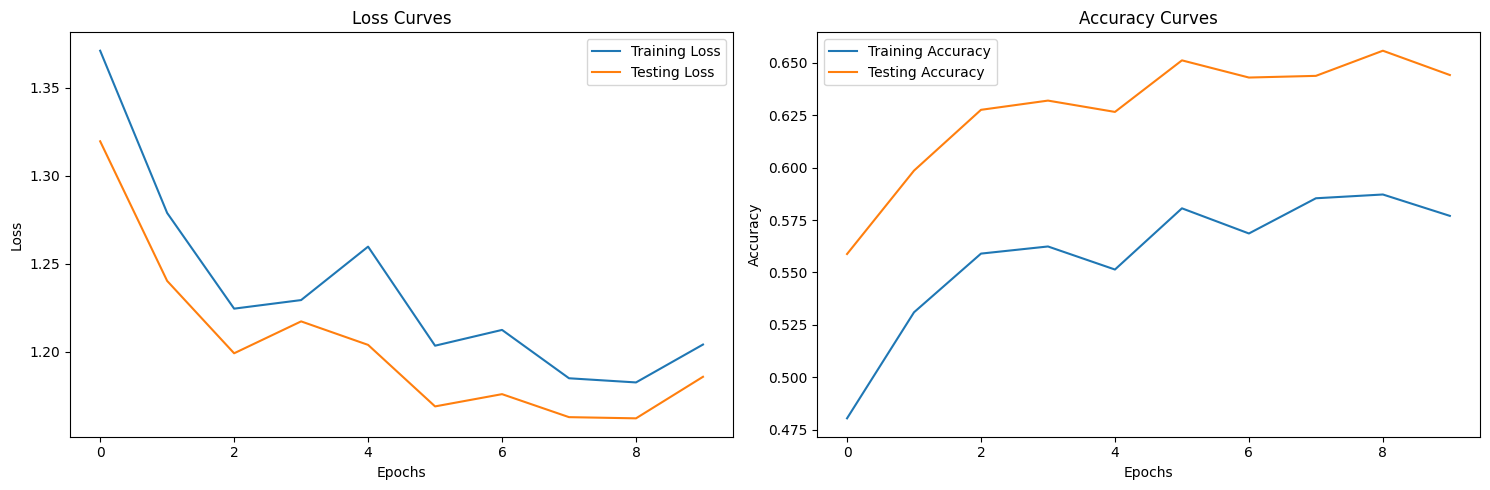

In [5]:
from modular.utils import analyze_model_performance,plot_training_results
analyze_model_performance(results)
plot_training_results(results)

In [6]:
# %load_ext tensorboard
# %tensorboard --logdir runs